In [6]:
import torch

# Device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
EPOCHS = 100
BATCH_SIZE = 32
LR = 0.001

In [63]:
import os
import zipfile
import opendatasets as od

# Replace 'dataset_name' with the name of the dataset you want to download
od.download('https://www.kaggle.com/datasets/vermaavi/food11')

Skipping, found downloaded files in "./food11" (use force=True to force download)


In [7]:
import os
from torch.utils.data import Dataset
from PIL import Image, ImageDraw, ImageFont

# Custom dataset that inherits from 
class Food11Dataset(Dataset):
    def __init__(self, dir, limit=None, transform=None):
        self.dir = dir
        self.transform = transform

        if limit is None:
            self.file_list = [file for file in os.listdir(dir) if file.endswith('.jpg')]
        else:
            self.file_list = [file for file in os.listdir(dir) if file.endswith('.jpg')][:limit]
        # Get the list of files in the directory, up to the limit
        

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        path = os.path.join(self.dir, self.file_list[idx])
        
        image = Image.open(path)

        noisy = self.add_watermark(image)
        
        if self.transform:
            image = self.transform(image)
            noisy = self.transform(noisy)

        label = int(self.file_list[idx].split('_')[0])

        return image, noisy, label
    
    def add_watermark(self, image):
        noisy = image.copy()

        draw = ImageDraw.Draw(noisy)

        text = '01.11.2023'

        font = ImageFont.truetype('arial.ttf', 50)

        # Specify the color of the watermark (in this case, white)
        text_color = (255, 255, 255)

        # Draw the watermark on the image
        draw.text((10, 10), text, font=font, fill=text_color)

        return noisy

In [8]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # N, 3, 128, 128
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),  # N, 16, 64, 64
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # N, 32, 32, 32
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # N, 64, 16, 16
        )

        # N, 64, 16, 16
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # N, 32, 32, 32
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # N, 16, 64, 64
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # N, 3, 128, 128
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [9]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
])

training_data = Food11Dataset('../food11/training', transform=transform, limit=500)

validate_data = Food11Dataset('../food11/validation', transform=transform)

train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)

validate_dataloader = DataLoader(validate_data, batch_size=BATCH_SIZE, shuffle=True)

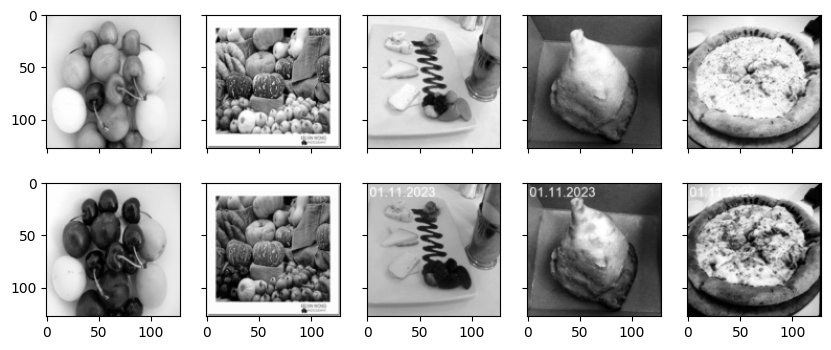

In [10]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(10,4))

for batch in train_dataloader:
    for i in range(5):
        axes[0][i].imshow(batch[0][i][0], cmap='gray')
        axes[1][i].imshow(batch[1][i][1], cmap='gray')
    break

In [ ]:
from tqdm import tqdm

model = Autoencoder()
model.to(DEVICE)

# model.load_state_dict(torch.load('latest.pth'))

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=0.00005)

for epoch in range(EPOCHS):

    for (original, noisy, labels) in tqdm(train_dataloader):
        noisy = noisy.to(DEVICE)
        original = original.to(DEVICE)

        output = model(noisy)
        loss = criterion(output, original)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss = loss.item()

    # Save loss to a file called loss.txt
    with open('loss.txt', 'a') as f:
        f.write(str(loss) + '\n')

    # Save the model as latest.pth
    torch.save(model.state_dict(), 'latest.pth')

    print(f'Epoch {epoch+1}, Loss: {loss:.4f}')

100%|██████████| 16/16 [01:02<00:00,  3.89s/it]


Epoch 1, Loss: 0.0896


100%|██████████| 16/16 [02:44<00:00, 10.30s/it]


Epoch 2, Loss: 0.0596


100%|██████████| 16/16 [00:49<00:00,  3.10s/it]


Epoch 3, Loss: 0.0356


100%|██████████| 16/16 [02:45<00:00, 10.35s/it]


Epoch 4, Loss: 0.0244


100%|██████████| 16/16 [00:41<00:00,  2.57s/it]


Epoch 5, Loss: 0.0186


100%|██████████| 16/16 [00:39<00:00,  2.47s/it]


Epoch 6, Loss: 0.0182


100%|██████████| 16/16 [00:41<00:00,  2.57s/it]


Epoch 7, Loss: 0.0127


100%|██████████| 16/16 [00:40<00:00,  2.56s/it]


Epoch 8, Loss: 0.0158


100%|██████████| 16/16 [03:58<00:00, 14.93s/it]


Epoch 9, Loss: 0.0146


100%|██████████| 16/16 [00:37<00:00,  2.37s/it]


Epoch 10, Loss: 0.0127


 44%|████▍     | 7/16 [00:17<00:20,  2.29s/it]